In [1]:
import pandas as pd
import numpy as np
import sys
import os
import random
from pathlib import Path
import imageio
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.figure_factory as ff
from plotly import tools
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn import metrics
from keras import optimizers
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPool2D, Dropout, BatchNormalization,LeakyReLU
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping, ReduceLROnPlateau, LearningRateScheduler
from keras import utils
import tensorflow

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
IMAGE_PATH = '/content/drive/MyDrive/colab_notebooks/data/Capstone/bee_imgs/'
IMAGE_WIDTH = 100
IMAGE_HEIGHT = 100
IMAGE_CHANNELS = 3
RANDOM_STATE = 42
TEST_SIZE = 0.2
VAL_SIZE = 0.2
CONV_2D_DIM_1 = 16
CONV_2D_DIM_2 = 16
CONV_2D_DIM_3 = 32
CONV_2D_DIM_4 = 64
MAX_POOL_DIM = 2
KERNEL_SIZE = 3
BATCH_SIZE = 32
PATIENCE = 5
NO_EPOCHS_1 = 5
NO_EPOCHS_2 = 10
NO_EPOCHS_3 = 50

In [4]:
bee_df = pd.read_csv("/content/drive/MyDrive/colab_notebooks/data/Capstone/bee_data.csv")
bee_df.head(10)

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
5,041_071.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
6,041_065.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
7,041_064.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
8,041_070.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker
9,041_058.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker


In [5]:
image_files = list(os.listdir(IMAGE_PATH))
print("Number of image files: {}".format(len(image_files)))

Number of image files: 5173


In [6]:
file_names = list(bee_df['file'])
print("Matching image names: {}".format(len(set(file_names).intersection(image_files))))

Matching image names: 5172


In [7]:
def read_image_sizes(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    return list(image.shape)

In [8]:
m = np.stack(bee_df['file'].apply(read_image_sizes))
df = pd.DataFrame(m,columns=['width','height','color'])
bee_df = pd.concat([bee_df,df],axis=1, sort=False)
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3


In [9]:
bee_df = bee_df.replace({'location':'Athens, Georgia, USA'}, 'Athens, GA, USA')
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3


In [10]:
bee_df['date_time'] = pd.to_datetime(bee_df['date'] + ' ' + bee_df['time'])
bee_df["year"] = bee_df['date_time'].dt.year
bee_df["month"] = bee_df['date_time'].dt.month
bee_df["day"] = bee_df['date_time'].dt.day
bee_df["hour"] = bee_df['date_time'].dt.hour
bee_df["minute"] = bee_df['date_time'].dt.minute

In [11]:
bee_df.head()

,file,date,time,location,zip code,subspecies,health,pollen_carrying,caste,width,height,color,date_time,year,month,day,hour,minute
0,041_066.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,115,164,3,2018-08-28 16:07:00,2018,8,28,16,7
1,041_072.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,201,90,3,2018-08-28 16:07:00,2018,8,28,16,7
2,041_073.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,132,167,3,2018-08-28 16:07:00,2018,8,28,16,7
3,041_067.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,134,97,3,2018-08-28 16:07:00,2018,8,28,16,7
4,041_059.png,8/28/18,16:07,"Alvin, TX, USA",77511,-1,hive being robbed,False,worker,147,106,3,2018-08-28 16:07:00,2018,8,28,16,7


In [12]:
train_df, test_df = train_test_split(bee_df, test_size=TEST_SIZE, 
                                     random_state=RANDOM_STATE, 
                                     stratify=bee_df['health'])

train_df, val_df = train_test_split(train_df, test_size=VAL_SIZE, 
                                    random_state=RANDOM_STATE, 
                                    stratify=train_df['health'])

In [13]:
print("Train set rows: {}".format(train_df.shape[0]))
print("Test  set rows: {}".format(test_df.shape[0]))
print("Val   set rows: {}".format(val_df.shape[0]))

Train set rows: 3309
Test  set rows: 1035
Val   set rows: 828


In [14]:
def read_image(file_name):
    image = skimage.io.imread(IMAGE_PATH + file_name)
    image = skimage.transform.resize(image, (IMAGE_WIDTH, IMAGE_HEIGHT), mode='reflect')
    return image[:,:,:IMAGE_CHANNELS]

In [15]:
def categories_encoder(dataset, var='health'):
    X = np.stack(dataset['file'].apply(read_image))
    y = pd.get_dummies(dataset[var], drop_first=False)
    return X, y

In [16]:
X_train, y_train = categories_encoder(train_df)
X_val, y_val = categories_encoder(val_df)
X_test, y_test = categories_encoder(test_df)

### Baseline CNN

In [17]:
model1 = Sequential()


model1.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model1.add(MaxPool2D(MAX_POOL_DIM))
model1.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
model1.add(Flatten())
model1.add(Dense(y_train.columns.size, activation='softmax'))


model1.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [18]:
model1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 100, 100, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 50, 50, 16)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 50, 50, 16)        2320      
                                                                 
 flatten (Flatten)           (None, 40000)             0         
                                                                 
 dense (Dense)               (None, 6)                 240006    
                                                                 
Total params: 242,774
Trainable params: 242,774
Non-trainable params: 0
__________________________________________________

In [19]:
history1 = model1.fit(
    X_train, y_train,
    validation_data=(X_val, y_val),
    epochs=10,
    batch_size=256,
    verbose=1
)

Epoch 1/10
13/13 [==============================] - 10s 100ms/step - loss: 1.2416 - accuracy: 0.6074 - val_loss: 1.0358 - val_accuracy: 0.6546
Epoch 2/10
13/13 [==============================] - 1s 48ms/step - loss: 0.9030 - accuracy: 0.6646 - val_loss: 0.7789 - val_accuracy: 0.6872
Epoch 3/10
13/13 [==============================] - 1s 48ms/step - loss: 0.6470 - accuracy: 0.7504 - val_loss: 0.5660 - val_accuracy: 0.7923
Epoch 4/10
13/13 [==============================] - 1s 48ms/step - loss: 0.4606 - accuracy: 0.8338 - val_loss: 0.4438 - val_accuracy: 0.8225
Epoch 5/10
13/13 [==============================] - 1s 48ms/step - loss: 0.3510 - accuracy: 0.8631 - val_loss: 0.4056 - val_accuracy: 0.8502
Epoch 6/10
13/13 [==============================] - 1s 48ms/step - loss: 0.2850 - accuracy: 0.8891 - val_loss: 0.3829 - val_accuracy: 0.8406
Epoch 7/10
13/13 [==============================] - 1s 48ms/step - loss: 0.2519 - accuracy: 0.9033 - val_loss: 0.3672 - val_accuracy: 0.8502
Epoch 8/10


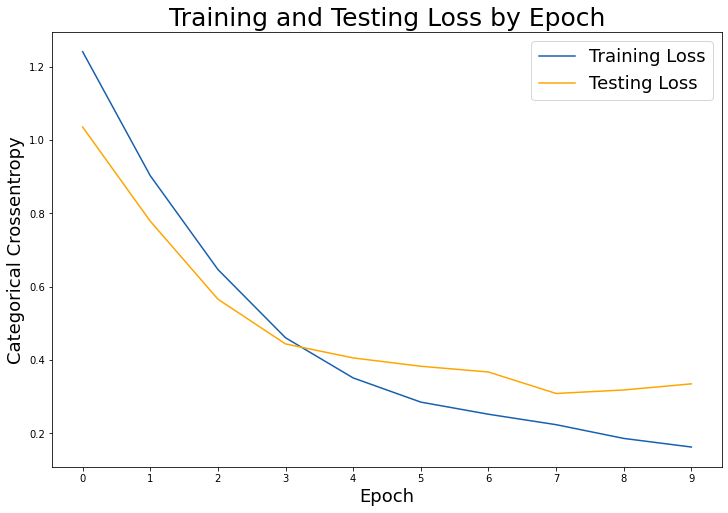

In [20]:
def plot_loss(history):
    train_loss = history.history['loss']
    test_loss = history.history['val_loss']

    # Set figure size
    plt.figure(figsize=(12, 8))

    # Generate line plot of training, testing loss over epochs
    plt.plot(train_loss, label='Training Loss', color='#185fad')
    plt.plot(test_loss, label='Testing Loss', color='orange')

    # Set title
    plt.title('Training and Testing Loss by Epoch', fontsize = 25)
    plt.xlabel('Epoch', fontsize = 18)
    plt.ylabel('Categorical Crossentropy', fontsize = 18)
    plt.xticks(np.arange(10), np.arange(10))

    plt.legend(fontsize = 18);

plot_loss(history1)

In [21]:
image_generator = ImageDataGenerator(
        featurewise_center=False,
        samplewise_center=False,
        featurewise_std_normalization=False,
        samplewise_std_normalization=False,
        zca_whitening=False,
        rotation_range=180,
        zoom_range = 0.1, 
        width_shift_range=0.1,
        height_shift_range=0.1, 
        horizontal_flip=True,
        vertical_flip=True)
image_generator.fit(X_train)

In [22]:
model1_aug = model1.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_1,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



Epoch 1/5
103/103 [==============================] - 8s 73ms/step - loss: 0.5312 - accuracy: 0.7939 - val_loss: 0.3447 - val_accuracy: 0.8780
Epoch 2/5
103/103 [==============================] - 11s 104ms/step - loss: 0.4112 - accuracy: 0.8244 - val_loss: 0.3398 - val_accuracy: 0.8684
Epoch 3/5
103/103 [==============================] - 8s 80ms/step - loss: 0.3613 - accuracy: 0.8495 - val_loss: 0.3248 - val_accuracy: 0.8696
Epoch 4/5
103/103 [==============================] - 8s 74ms/step - loss: 0.3379 - accuracy: 0.8595 - val_loss: 0.2313 - val_accuracy: 0.8925
Epoch 5/5
103/103 [==============================] - 10s 93ms/step - loss: 0.2847 - accuracy: 0.8797 - val_loss: 0.2488 - val_accuracy: 0.8913


In [23]:
# summarize history for accuracy
def plot_acc_and_loss(model):
  plt.figure(figsize=(15,10))
  plt.plot(model.history['accuracy'])
  plt.plot(model.history['val_accuracy'])
  plt.title('Accuracy', fontsize = 15)
  plt.ylabel('Accuracy')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()
# summarize history for loss
  plt.figure(figsize=(15,10))
  plt.plot(model.history['loss'])
  plt.plot(model.history['val_loss'])
  plt.title('Loss', fontsize = 15)
  plt.ylabel('Loss')
  plt.xlabel('Epoch')
  plt.legend(['Train', 'Validation'], loc='upper left')
  plt.show()

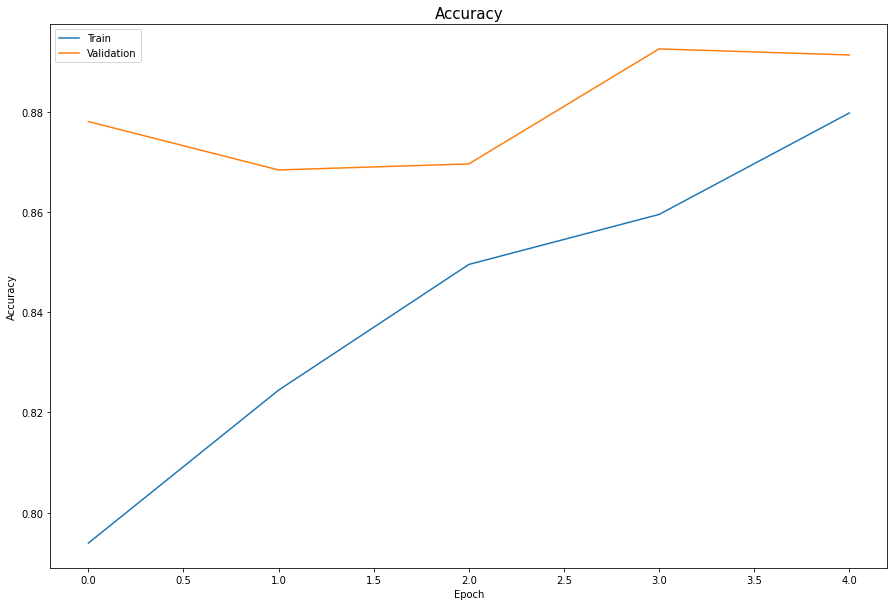

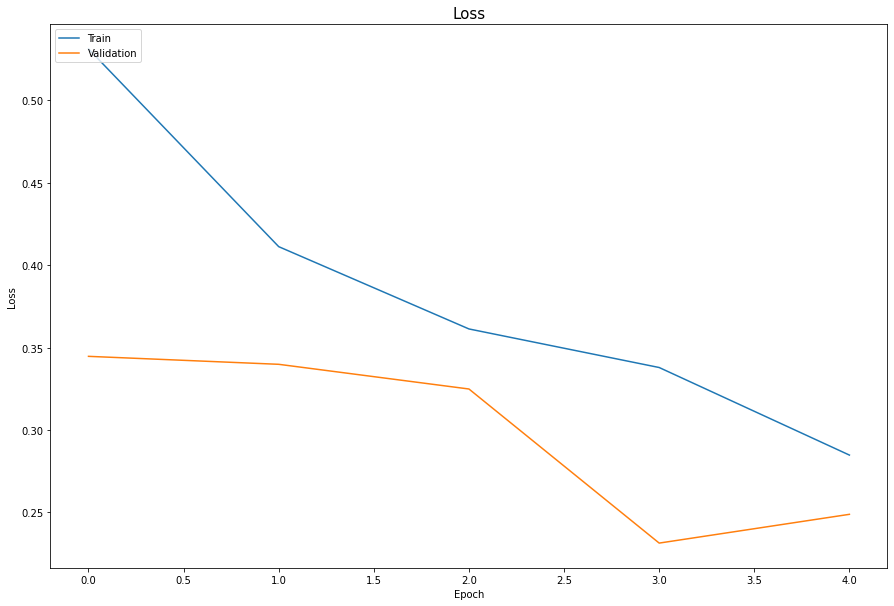

In [25]:
plot_acc_and_loss(model1_aug)

#### Model Evaluation

In [26]:
score = model1.evaluate(X_test, y_test, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

33/33 [==============================] - 0s 7ms/step - loss: 0.2357 - accuracy: 0.8966
Test loss: 0.23568060994148254
Test accuracy: 0.8966183662414551


In [27]:
def test_accuracy_report(model):
    predicted = model.predict(X_test)
    test_predicted = np.argmax(predicted, axis=1)
    test_truth = np.argmax(y_test.values, axis=1)
    print(metrics.classification_report(test_truth, test_predicted, target_names=y_test.columns)) 
    test_res = model.evaluate(X_test, y_test.values, verbose=0)
    print('Loss function: %s, accuracy:' % test_res[0], test_res[1])

In [28]:
test_accuracy_report(model1)

33/33 [==============================] - 1s 6ms/step
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.75      0.43      0.55        95
              ant problems       0.90      0.99      0.94        91
  few varrao, hive beetles       0.64      0.84      0.72       116
                   healthy       0.97      0.99      0.98       677
         hive being robbed       0.96      0.52      0.68        50
             missing queen       0.46      1.00      0.63         6

                  accuracy                           0.90      1035
                 macro avg       0.78      0.79      0.75      1035
              weighted avg       0.90      0.90      0.89      1035

Loss function: 0.23568060994148254, accuracy: 0.8966183662414551


In [29]:
model_drop=Sequential()
model_drop.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model_drop.add(MaxPool2D(MAX_POOL_DIM))
# Dropout Layer
model_drop.add(Dropout(0.4))
model_drop.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Dropout Layer
model_drop.add(Dropout(0.4))
model_drop.add(Flatten())
model_drop.add(Dense(y_train.columns.size, activation='softmax'))
model_drop.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [30]:
model_drop_aug  = model_drop.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_2,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE)

Epoch 1/10


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 9s 75ms/step - loss: 1.2076 - accuracy: 0.6398 - val_loss: 1.2729 - val_accuracy: 0.5568
Epoch 2/10
103/103 [==============================] - 8s 73ms/step - loss: 0.7110 - accuracy: 0.7307 - val_loss: 0.6917 - val_accuracy: 0.7186
Epoch 3/10
103/103 [==============================] - 8s 78ms/step - loss: 0.5296 - accuracy: 0.7806 - val_loss: 0.5053 - val_accuracy: 0.7850
Epoch 4/10
103/103 [==============================] - 10s 96ms/step - loss: 0.4607 - accuracy: 0.8147 - val_loss: 0.4335 - val_accuracy: 0.8140
Epoch 5/10
103/103 [==============================] - 10s 98ms/step - loss: 0.4067 - accuracy: 0.8326 - val_loss: 0.4540 - val_accuracy: 0.8128
Epoch 6/10
103/103 [==============================] - 8s 77ms/step - loss: 0.3980 - accuracy: 0.8338 - val_loss: 0.3831 - val_accuracy: 0.8285
Epoch 7/10
103/103 [==============================] - 7s 72ms/step - loss: 0.3563 - accuracy: 0.8416 - val_loss: 0.3301 - val_accuracy: 0.8635
Epoch 8/

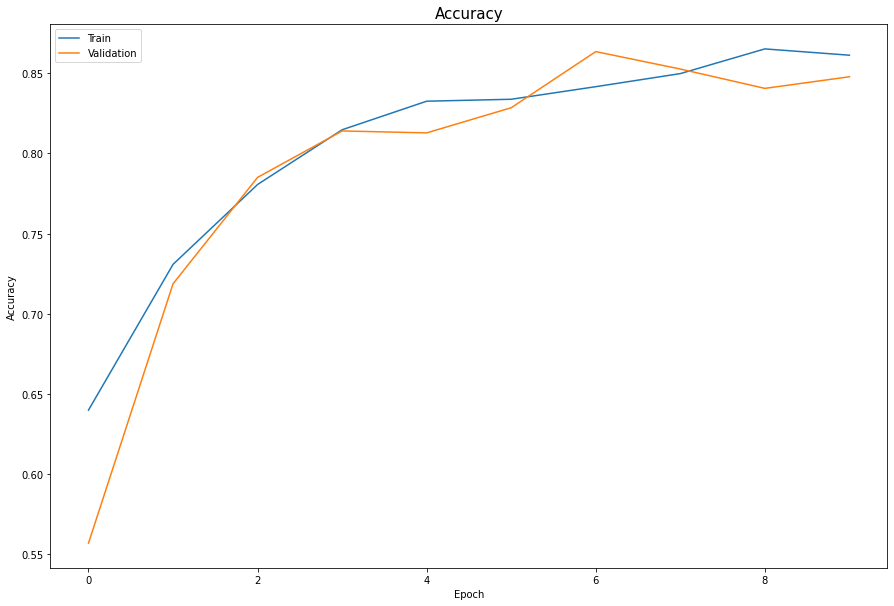

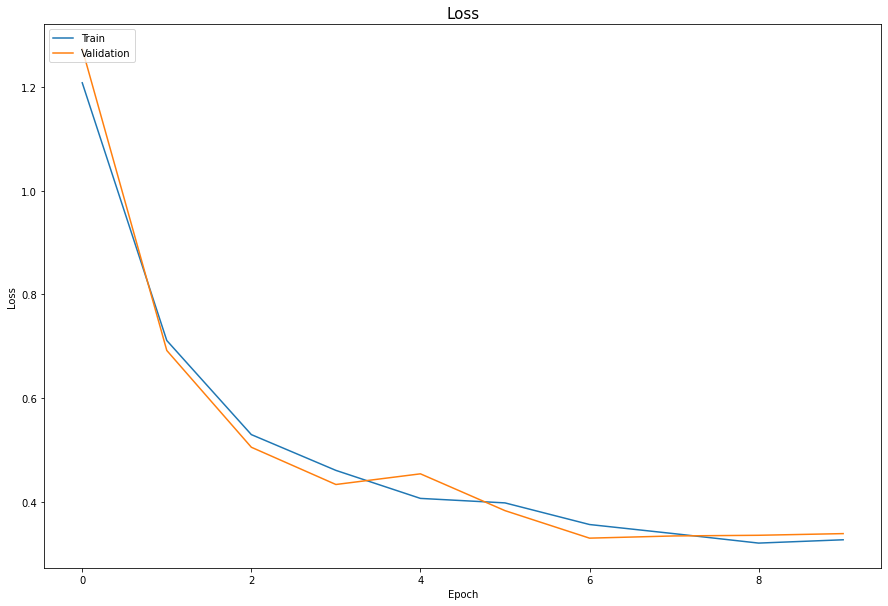

In [31]:
plot_acc_and_loss(model_drop)

In [32]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.995 ** (x+NO_EPOCHS_3))
earlystopper = EarlyStopping(monitor='loss', patience=PATIENCE, verbose=1)

In [33]:
model_lr=Sequential()
model_lr.add(Conv2D(CONV_2D_DIM_1, kernel_size=KERNEL_SIZE, input_shape=(IMAGE_WIDTH, IMAGE_HEIGHT,IMAGE_CHANNELS), activation='relu', padding='same'))
model_lr.add(MaxPool2D(MAX_POOL_DIM))
# Add dropouts to the model
model_lr.add(Dropout(0.4))
model_lr.add(Conv2D(CONV_2D_DIM_2, kernel_size=KERNEL_SIZE, activation='relu', padding='same'))
# Add dropouts to the model
model_lr.add(Dropout(0.4))
model_lr.add(Flatten())
model_lr.add(Dense(y_train.columns.size, activation='softmax'))
model_lr.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

In [34]:
train_model_lr  = model_lr.fit_generator(image_generator.flow(X_train, y_train, batch_size=BATCH_SIZE),
                        epochs=NO_EPOCHS_3,
                        validation_data=[X_val, y_val],
                        steps_per_epoch=len(X_train)/BATCH_SIZE,
                        callbacks=[earlystopper, annealer])

Epoch 1/50


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:5: UserWarning:

`Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.



103/103 [==============================] - 10s 89ms/step - loss: 1.1849 - accuracy: 0.6286 - val_loss: 0.9513 - val_accuracy: 0.7017 - lr: 7.7831e-04
Epoch 2/50
103/103 [==============================] - 11s 103ms/step - loss: 0.6940 - accuracy: 0.7380 - val_loss: 0.5497 - val_accuracy: 0.7717 - lr: 7.7442e-04
Epoch 3/50
103/103 [==============================] - 8s 80ms/step - loss: 0.5198 - accuracy: 0.7857 - val_loss: 0.4854 - val_accuracy: 0.8007 - lr: 7.7055e-04
Epoch 4/50
103/103 [==============================] - 9s 82ms/step - loss: 0.4470 - accuracy: 0.8084 - val_loss: 0.4288 - val_accuracy: 0.8068 - lr: 7.6670e-04
Epoch 5/50
103/103 [==============================] - 8s 77ms/step - loss: 0.3950 - accuracy: 0.8286 - val_loss: 0.3860 - val_accuracy: 0.8502 - lr: 7.6286e-04
Epoch 6/50
103/103 [==============================] - 8s 81ms/step - loss: 0.3575 - accuracy: 0.8380 - val_loss: 0.3270 - val_accuracy: 0.8684 - lr: 7.5905e-04
Epoch 7/50
103/103 [============================

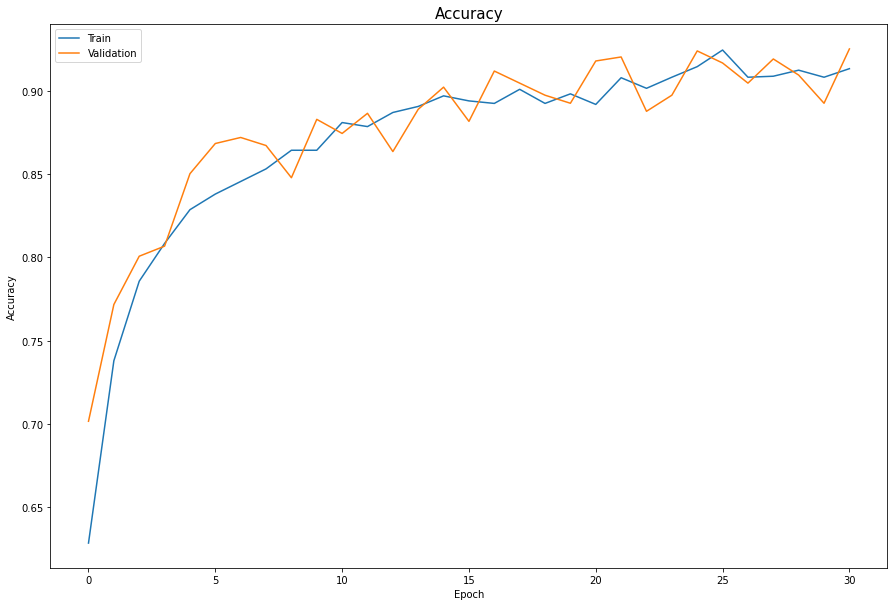

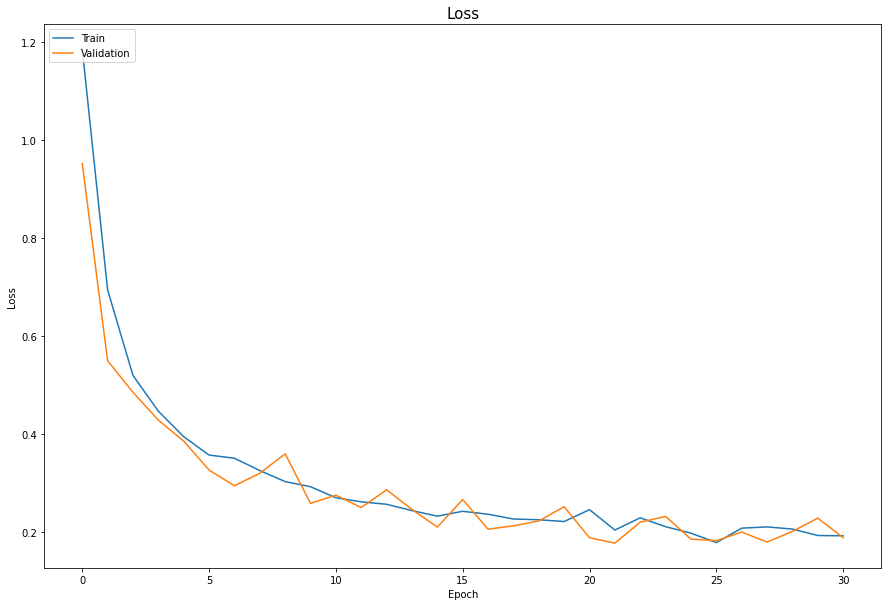

In [35]:
plot_acc_and_loss(train_model_lr)

In [36]:
test_preds = model_lr.predict(X_test)

33/33 [==============================] - 0s 4ms/step


In [37]:
test_preds = np.argmax(test_preds, axis = 1)
test_true = np.argmax(y_test.values, axis = 1)

In [38]:
print("Classification report")
print(metrics.classification_report(test_true, test_preds, target_names=y_test.columns))

Classification report
                            precision    recall  f1-score   support

Varroa, Small Hive Beetles       0.74      0.71      0.72        95
              ant problems       0.92      0.99      0.95        91
  few varrao, hive beetles       0.75      0.71      0.73       116
                   healthy       0.98      0.99      0.98       677
         hive being robbed       0.92      0.92      0.92        50
             missing queen       0.86      1.00      0.92         6

                  accuracy                           0.93      1035
                 macro avg       0.86      0.88      0.87      1035
              weighted avg       0.92      0.93      0.92      1035



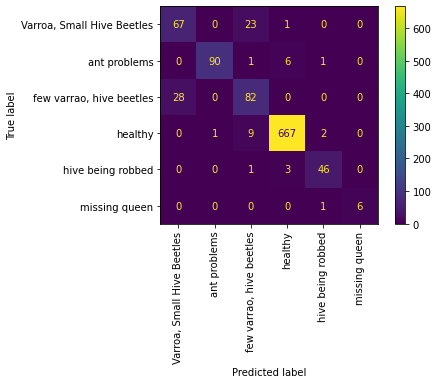

In [39]:
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, 
                                        test_true, 
                                        display_labels = list(y_test.columns),
                                        xticks_rotation = 'vertical');

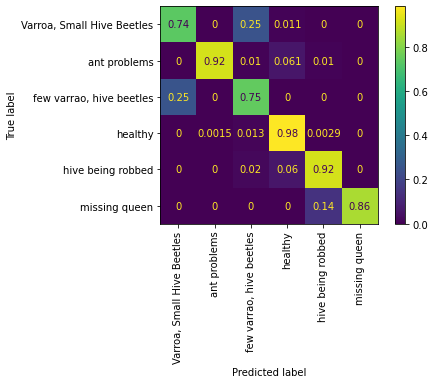

In [40]:
metrics.ConfusionMatrixDisplay.from_predictions(test_preds, 
                                        test_true, 
                                        display_labels = list(y_test.columns),
                                        xticks_rotation = 'vertical',
                                        normalize = 'true');

In [41]:
model1.save('/content/drive/MyDrive/colab_notebooks/models/model_1_health')
model_drop.save('/content/drive/MyDrive/colab_notebooks/models/model_drop_health')
model_lr.save('/content/drive/MyDrive/colab_notebooks/models/model_lr_health')